In [1]:
from STIFMaps import STIFMap_generation
from STIFMaps.misc import get_step

import os
import re
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import interpolate
from PIL import Image
import tifffile
import time

# Directories
project_dir = '/home/steve/Projects/WeaverLab/STIFMaps'
IPMN_directory = os.path.join(project_dir, "IPMN_images")
STIFMaps_directory = os.path.join(project_dir, "STIFMap_normalized_images_v2")
os.makedirs(STIFMaps_directory, exist_ok=True)

# Define the base name and the number of rows and columns
base_name = "27620"
base_name_C0 = "27620_C0_full_tile"
base_name_C1 = "27620_C1_full_tile"
num_rows = 6  # Example: Number of rows in the grid of tiles
num_cols = 7  # Example: Number of columns in the grid of tiles

# Create a list of file names for C0 and C1 tiles
C0_files = [f"{base_name_C0}_{i}_{j}.tif" for i in range(num_rows) for j in range(num_cols)]
C1_files = [f"{base_name_C1}_{i}_{j}.tif" for i in range(num_rows) for j in range(num_cols)]

# STIFMap models
models = [
    '/Users/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1171.pt',
    '/Users/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1000.pt',
    '/Users/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1043.pt',
    '/Users/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1161.pt',
    '/Users/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1180.pt'
]

# Parameters
scale_factor = 2.712
step = get_step(40, scale_factor)
square_side = get_step(224, scale_factor)
batch_size = 100

print('Step size is ' + str(step) + ' pixels')
print('Side length for a square is ' + str(square_side) + ' pixels')

Step size is 14 pixels
Side length for a square is 82 pixels


In [4]:
# Function to check image dimensions
def check_image_dimensions(image_path):
    try:
        with tifffile.TiffFile(image_path) as tif:
            width, height = tif.pages[0].shape[:2]
            print(f"File: {os.path.basename(image_path)}, Dimensions: {width}x{height}")
            return width, height
    except Exception as e:
        print(f"Error opening {image_path}: {e}")

# Function to stitch images together
def stitch_images(output_filename, base_name, rows, cols, image_format='png'):
    sample_image_path = f"{base_name}_{0}_{0}.{image_format}"
    sample_image = Image.open(sample_image_path)
    image_width, image_height = sample_image.size

    stitched_width = cols * image_width
    stitched_height = rows * image_height
    stitched_image = Image.new('RGB', (stitched_width, stitched_height))

    for row in range(rows):
        for col in range(cols):
            image_filename = f"{base_name}_{row}_{col}.{image_format}"
            image = Image.open(image_filename)
            x = col * image_width
            y = row * image_height
            stitched_image.paste(image, (x, y))

    stitched_image.save(output_filename)
    print(f"Stitched image saved as {output_filename}")

# Function to convert seconds to hours, minutes, and seconds
def convert_seconds_to_hms(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    time_parts = []
    if hours > 0:
        time_parts.append(f"{hours} hours")
    if minutes > 0:
        time_parts.append(f"{minutes} minutes")
    time_parts.append(f"{seconds:.1f} seconds")
    return ", ".join(time_parts)

# Function to generate the output path for STIFMap images
def gen_output_path(filename):
    pattern = r"_tile_(\d+)_(\d+)\.tif$"
    match = re.search(pattern, filename)
    if match:
        row = int(match.group(1))
        col = int(match.group(2))
    else:
        print("Error: row or column name not found in tiled C0 or C1 file name.")
        return None

    output_file = f"{base_name}_STIFMap_{row}_{col}.png"
    return os.path.join(STIFMaps_directory, output_file)

# Function to generate and save the STIFMap
def run_STIFMap(dapi, collagen, name, step, models, batch_size, square_side):
    start_time = time.perf_counter()

    z_out = STIFMap_generation.generate_STIFMap(dapi, collagen, name, step, models=models,
                                               mask=False, batch_size=batch_size, square_side=square_side,
                                               save_dir=False)

    end_time = time.perf_counter()
    print("Elapsed time:", convert_seconds_to_hms(end_time - start_time))

    output_image = np.mean(z_out, axis=0)

    # Normalize the image to the range [0, 1]
    # output_image_normalized = output_image / output_image.max()

    # Normalize the image to the range [0, 1] globally
    global_min = np.min(output_image)
    global_max = np.max(output_image)
    output_image_normalized = (output_image - global_min) / (global_max - global_min)

    # Save the image using matplotlib
    output_path = gen_output_path(dapi)
    plt.imsave(output_path, output_image_normalized, cmap="viridis")
    print(f"Saved image: {output_path}")

    # Save the raw stiffness values as a NumPy array
    stiffness_values_path = output_path.replace(".png", ".npy")
    np.save(stiffness_values_path, output_image)
    print(f"Saved stiffness values: {stiffness_values_path}")

# Function to check if a tile has already been processed
def is_tile_completed(output_path):
    return os.path.exists(output_path)


Processing: 27620_C0_full_tile_4_0.tif and 27620_C1_full_tile_4_0.tif
Device is cpu


C:\Users\steve\miniconda3\envs\STIFMaps\lib\site-packages\STIFMaps\STIFMap_generation.py:145: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(np.moveaxis(im, 0, -1))


Image shape is (3, 5003, 5003)
Num squares in x direction is 352
Num squares in y direction is 352
Time taken to predict squares is 536.0287847518921
Time taken to predict squares is 985.9525878429413
Time taken to predict squares is 1451.8528776168823
Time taken to predict squares is 1905.277315378189
Time taken to predict squares is 2351.807848930359
Total time taken is 2353.125497341156
Elapsed time: 39 minutes, 13.2 seconds
Saved image: /Users/steve/Projects/WeaverLab/STIFMaps\STIFMap_normalized_images_v2\27620_STIFMap_4_0.png
Saved stiffness values: /Users/steve/Projects/WeaverLab/STIFMaps\STIFMap_normalized_images_v2\27620_STIFMap_4_0.npy


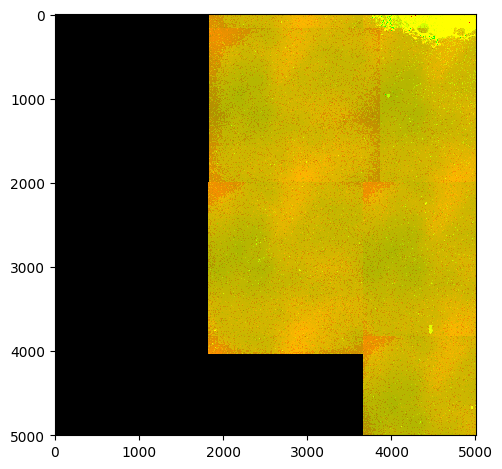

In [5]:
# Main: Loop through all the tiled C0 and C1 images and pass each one to run_STIFMap()
# for i in range(num_rows):
#     for j in range(num_cols):
#         dapi = os.path.join(IPMN_directory, 'normalized_tiled_v2', C0_files[i * num_cols + j])
#         collagen = os.path.join(IPMN_directory, 'normalized_tiled_v2', C1_files[i * num_cols + j])
#         output_path = gen_output_path(dapi)

#         # Check if the tile has already been processed
#         if is_tile_completed(output_path):
#             print(f"Skipping already processed tile: {C0_files[i * num_cols + j]} and {C1_files[i * num_cols + j]}")
#             continue

#         print(f"Processing: {C0_files[i * num_cols + j]} and {C1_files[i * num_cols + j]}")

#         run_STIFMap(
#             dapi=dapi,
#             collagen=collagen,
#             name='test',
#             step=step,
#             models=models,
#             batch_size=batch_size,
#             square_side=square_side
#         )

# Stitch the processed tiles back together
# stitched_output_path = os.path.join(STIFMaps_directory, f"{base_name}_STIFMap_stitched.png")
# stitch_images(stitched_output_path, base_name, num_rows, num_cols, image_format='png')

i = 4
j = 0
dapi = os.path.join(IPMN_directory, 'normalized_tiled_v2', C0_files[i * num_cols + j])
collagen = os.path.join(IPMN_directory, 'normalized_tiled_v2', C1_files[i * num_cols + j])
print(f"Processing: {C0_files[i * num_cols + j]} and {C1_files[i * num_cols + j]}")
run_STIFMap(
    dapi=dapi,
    collagen=collagen,
    name='test',
    step=step,
    models=models,
    batch_size=batch_size,
    square_side=square_side
)

Processing: 27620_C0_full_tile_0_4.tif and 27620_C1_full_tile_0_4.tif
Device is cpu


C:\Users\steve\miniconda3\envs\STIFMaps\lib\site-packages\STIFMaps\STIFMap_generation.py:145: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(np.moveaxis(im, 0, -1))


Image shape is (3, 5003, 5003)
Num squares in x direction is 352
Num squares in y direction is 352
Time taken to predict squares is 478.7199811935425
Time taken to predict squares is 946.2417979240417
Time taken to predict squares is 1416.7002382278442
Time taken to predict squares is 1890.684219121933
Time taken to predict squares is 2364.3124046325684
Total time taken is 2366.035384654999
Elapsed time: 39 minutes, 26.1 seconds
Saved image: /Users/steve/Projects/WeaverLab/STIFMaps\STIFMap_normalized_images_v2\27620_STIFMap_0_4.png
Saved stiffness values: /Users/steve/Projects/WeaverLab/STIFMaps\STIFMap_normalized_images_v2\27620_STIFMap_0_4.npy


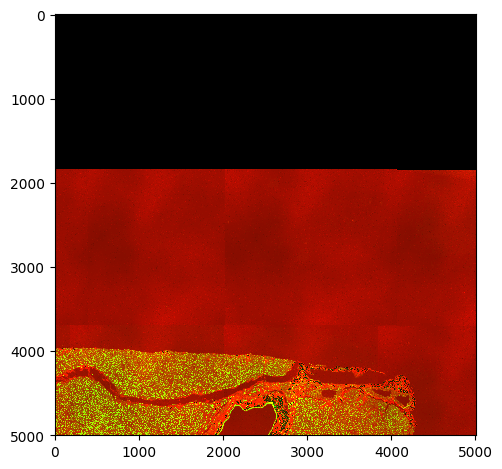

In [6]:
i = 0
j = 4
dapi = os.path.join(IPMN_directory, 'normalized_tiled_v2', C0_files[i * num_cols + j])
collagen = os.path.join(IPMN_directory, 'normalized_tiled_v2', C1_files[i * num_cols + j])
print(f"Processing: {C0_files[i * num_cols + j]} and {C1_files[i * num_cols + j]}")
run_STIFMap(
    dapi=dapi,
    collagen=collagen,
    name='test',
    step=step,
    models=models,
    batch_size=batch_size,
    square_side=square_side
)

Processing: 27620_C0_full_tile_1_4.tif and 27620_C1_full_tile_1_4.tif
Device is cpu


C:\Users\steve\miniconda3\envs\STIFMaps\lib\site-packages\STIFMaps\STIFMap_generation.py:145: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(np.moveaxis(im, 0, -1))


Image shape is (3, 5003, 5003)
Num squares in x direction is 352
Num squares in y direction is 352
Time taken to predict squares is 493.7064161300659
Time taken to predict squares is 984.1162750720978
Time taken to predict squares is 1475.6304664611816
Time taken to predict squares is 1960.0906002521515
Time taken to predict squares is 2444.845263004303
Total time taken is 2446.7868707180023
Elapsed time: 40 minutes, 46.9 seconds
Saved image: /Users/steve/Projects/WeaverLab/STIFMaps\STIFMap_normalized_images_v2\27620_STIFMap_1_4.png
Saved stiffness values: /Users/steve/Projects/WeaverLab/STIFMaps\STIFMap_normalized_images_v2\27620_STIFMap_1_4.npy


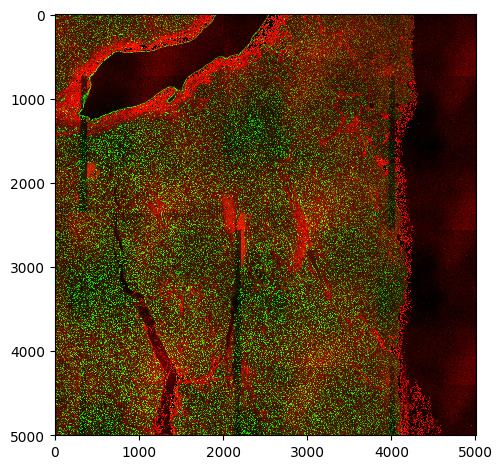

In [7]:
i = 1
j = 4
dapi = os.path.join(IPMN_directory, 'normalized_tiled_v2', C0_files[i * num_cols + j])
collagen = os.path.join(IPMN_directory, 'normalized_tiled_v2', C1_files[i * num_cols + j])
print(f"Processing: {C0_files[i * num_cols + j]} and {C1_files[i * num_cols + j]}")
run_STIFMap(
    dapi=dapi,
    collagen=collagen,
    name='test',
    step=step,
    models=models,
    batch_size=batch_size,
    square_side=square_side
)